
# Evaluación del Mejor Modelo de Optuna en MNIST (PyTorch)

Este notebook muestra cómo ejecutar Optuna, reconstruir el mejor modelo encontrado, entrenarlo sobre todo el conjunto de entrenamiento y evaluarlo en el conjunto de prueba.


In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import optuna
from optuna.samplers import RandomSampler

## Dataset

In [3]:
# Dataset y transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


## Definición del modelo

In [4]:
# Definición del modelo
class SimpleNet(nn.Module):
    def __init__(self, n_units, dropout_rate):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, n_units)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(n_units, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Definición de la sintonización de hiperparámetros

In [5]:
# La función objective recibe el obejto trial y retorna alguna medida de desempeño.
# Debe incluir la definición, entrenamiento y validación del modelo.
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Espacio de búsqueda.
    # Dependiendo del algoritmo de muestreo se eligen:
    # a) todos los valores.
    # b) valores al azar.
    # c) valores según algún criterio de búsqueda (Bayesian Optimization)
    n_units = trial.suggest_int('n_units', 32, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Definición del modelo.
    model = SimpleNet(n_units, dropout_rate).to(device)

    # Se define el optimzador de acuerdo con la búsqueda.
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Función de costo.
    criterion = nn.CrossEntropyLoss()

    # Recordar que para la búsqueda de hiperparámetros se usan 3 conjuntos: Train,
    # Validation y Test.
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    # Ciclo de entrenamiento del modelo
    model.train()
    for epoch in range(5):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Evaluación sobre el conjunto de validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    # Se retorna el error, así que se búsca minimizar el error. Tmabién puede ser
    # que se quiera maximizar el accuracy.
    val_accuracy = correct / total
    return 1.0 - val_accuracy


In [6]:
# Se define el objeto study encargado de realizar la búsqueda. Por defecto se
# usa un sampler = TPESampler, pero puede usarse cualquiera en este listado:
# https://optuna-readthedocs-io.translate.goog/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc#pruning
study = optuna.create_study(direction='minimize')
# study = optuna.create_study(direction='minimize', sampler=RandomSampler())
print(f"Sampler is {study.sampler.__class__.__name__}")
study.optimize(objective, n_trials=10) #Se pasa la función objective y se define
# la cantidad máxima de iteraciones.

[I 2025-11-13 19:52:22,712] A new study created in memory with name: no-name-55d7ed90-f6eb-4048-b184-cc627908cf41


Sampler is TPESampler


[I 2025-11-13 19:53:15,940] Trial 0 finished with value: 0.06874999999999998 and parameters: {'n_units': 148, 'dropout_rate': 0.3190320726496736, 'learning_rate': 0.00016643528497976658, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.06874999999999998.
[I 2025-11-13 19:54:05,593] Trial 1 finished with value: 0.0954166666666667 and parameters: {'n_units': 35, 'dropout_rate': 0.1441715372737595, 'learning_rate': 0.00012692451220854938, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.06874999999999998.
[I 2025-11-13 19:54:53,992] Trial 2 finished with value: 0.03983333333333339 and parameters: {'n_units': 209, 'dropout_rate': 0.16763919227599447, 'learning_rate': 0.0013968224481059888, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.03983333333333339.
[I 2025-11-13 19:55:42,796] Trial 3 finished with value: 0.041166666666666685 and parameters: {'n_units': 218, 'dropout_rate': 0.3260868613336063, 'learning_rate': 0.0007873637050974537, 'optimizer': 'RMSprop'}. Best is

## Visualización de resultados

In [7]:
print('Mejores parámetros encontrados:')
print(study.best_params)

Mejores parámetros encontrados:
{'n_units': 209, 'dropout_rate': 0.16763919227599447, 'learning_rate': 0.0013968224481059888, 'optimizer': 'RMSprop'}


/tmp/ipython-input-1317441400.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

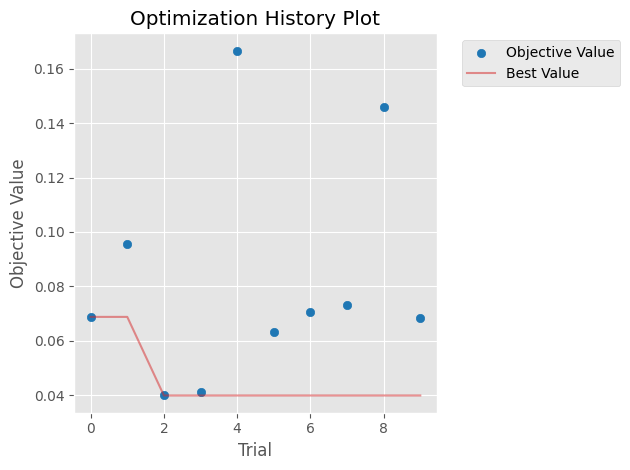

In [8]:
import optuna.visualization.matplotlib
optuna.visualization.matplotlib.plot_optimization_history(study)

In [9]:
optuna.visualization.plot_param_importances(study)

## Reentrenamiento del modelo con los mejores hiperparámetros y evaluación final sobre el conjunto de prueba.

In [10]:
# Extraer mejores hiperparámetros
best_params = study.best_params
n_units = best_params['n_units']
dropout_rate = best_params['dropout_rate']
optimizer_name = best_params['optimizer']
learning_rate = best_params['learning_rate']


In [11]:
# Reconstruir modelo final
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNet(n_units, dropout_rate).to(device)

if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

In [12]:
# Entrenar con todo el conjunto de entrenamiento
full_train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    for data, target in full_train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()


In [13]:

# Evaluar en el conjunto de prueba
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model.eval()
correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {avg_test_loss:.4f}')


Test accuracy: 0.9701
Test loss: 0.0992


## Actividad: Búsqueda de hiperparámetros

Para la base de datos Fashion Mnist, realizar una búsqueda de hiperparámetros que incluya:

1. Número adecuado de capas.
2. Número de neuronas por capa.
3. Tamaño del lote.
4. Learning Rate.

In [14]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.1MB/s]
